<a href="https://colab.research.google.com/github/BubuDavid/Fundamentos-de-Procesamiento-Digital-de-Imagenes/blob/main/tareas/tarea5/Tarea5_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se puede ver el notebook con el código en el siguiente link: https://colab.research.google.com/drive/1n_mdrrlk70UcSYfYx_mTJAAjscOYi1iF?usp=sharing

# Imports

In [11]:
# Importando librerías
import cv2 # Para manejar imágenes
import matplotlib.pyplot as plt # Para visualizar las imágenes (Se puede hacer de otra manera con una librería de google pero meh, este está bueno)
import numpy as np # Para operar matrices de manera sencilla

# Funciones auxiliares

In [185]:
# Desplegar histogramas
def show_histograms(imgs, bin_value = 20, colors = [None, "g"], titles = ["Normal", "No normal"], normalized = True, edgecolor = "black", cumulative = False, size = (15, 5), **kwargs):
	"""Muestra y regresa histogramas de las imágenes que le pases.

	Args:
		imgs (List[np.array]): Lista de imágenes a calcular sus histograms
		bin_value (int, optional): Rango de los bins en nuestros plots. Recomendado 20.
		colors (list, optional): Lista de colores para los histogramas. Recomendado [None, "g"].
		titles (list, optional): Lista de títulos para los histogramas. Recomendado ["Normal", "No normal"].
		normalized (bool, optional): Dicta si los histogramas están normalizados o no. Recomendado True.
		edgecolor (str, optional): El color del borde de cada bin, también se puede dejar en None si no quieres borde. Recomendado "black".
		cumulative (bool, optional): Esto indica si los histogramas son acumultivos o no. Recomendado False.
		size (tuple, optional): Tamaño de las gráficas. Recomendado (15, 5).

	Returns:
		hist: Lista con los histogramas calculados.
		bins: Lista con los bins calculados aunque usualmente son iguales todos.
	"""
	if type(imgs) != list:
		imgs = [imgs]
	if type(titles) != list:
		titles = [titles]
	
	flattens = np.array(list(map(lambda img: img.ravel(), imgs)))
	bins = np.array([np.linspace(0, 255, bin_value) for i in range(len(imgs))])
	hists = []
	fig, ax = plt.subplots(1, len(imgs), figsize = size)
	
	if len(imgs) == 1:
		img, b = imgs[0], bins[0]
		
		hist, b = np.histogram(img, bins = b)
		if normalized:
			hist = hist / img.size
		if cumulative:
			hist = np.cumsum(hist)
		ax.hist(b[:-1], b, weights = hist, color = colors[0], edgecolor = edgecolor, **kwargs)
		ax.set_title(titles[0])
		return hist, b
	else:
		for index in range(len(flattens)):
			img, b = imgs[index], bins[index]
			hist, b = np.histogram(img, bins = b)
			if normalized:
				hist = hist / img.size
			if cumulative:
				hist = np.cumsum(hist)
			
			ax[index].hist(b[:-1], b, weights = hist, color = colors[index], edgecolor = edgecolor, **kwargs)
			ax[index].set_title(titles[index])
			hists.append(hist)
	return hists, bins

In [190]:
def imcomplement(img):
	"""Función para generar el negativo de una imagen en blanco y negro
	Args:
		img (np.array): Imagen a negativizar

	Returns:
		negative_img: Imagen negativa
	"""
	return np.abs(255 - img)

In [192]:
# Credits: https://www.nzfaruqui.com/contrast-stretching-in-image-processing-using-matlab/
def imadjust(img,lim_in = [0, 1], lim_out = [0, 1], gamma=1, plot = False):
	"""Imagen que ajusta a un rango determinado con una gamma correction definida (Hace lo mismo que la función de matlab)

	Args:
		img (np.array): Imagen a transformar
		lim_in (list, optional): Limites de la imagen de input. Defaults to [0, 1].
		lim_out (list, optional): Limites de la imagen de output. Defaults to [0, 1].
		gamma (int, optional): Factor gamma de la función. Defaults to 1.
		plot (bool, optional): Si se desea graficar le función gamma. Defaults to False.

	Returns:
		adjusted_img: Imagen ajustada
	"""
	c, d = lim_in
	a, b = lim_out
	# Normalización para que esto funcione
	img_cp = img.copy()
	if np.max(img_cp) > 1:
		img_cp = img_cp / np.max(img_cp)

	# Básicamente esto es lo que hace imadjust ☝ ver la fuente para mayor información
	adj = (((img_cp - a) / (b - a)) ** gamma) * (d - c) + c
	# Regresando a las dimensiones originales
	adj = np.int64(adj / np.max(adj) * 255)

	# Grafica la función
	if plot:
		x = np.linspace(0, 1, 1000)
		y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
		plt.plot(x,y, c='g')
		plt.title(f'Función adjust con a={a}, b={b}, c={c}, d={d}, gamma={gamma}')
	return adj

In [186]:
# Mostrar imágenes
def show_img(img, size = (7, 7), is_gray = True, info = False):
	"""Muestra una imagen con tamaño específico.

	Args:
		img (np.array): Imagen que se desea mostrar
		size (tuple, optional): Tamaño relativo de la imagen. Recomendado (7, 7).
		is_gray (bool, optional): Si la imagen es en blanco y negro activar. Recomendado True.
		info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
	"""
	fig, axs = plt.subplots(figsize=size)
	if is_gray:
		axs.imshow(img, cmap='gray', vmin=0, vmax=255)
	else:
		axs.imshow(img)
	axs.axis("off")

	if info:
		print(f"Imagen de dimensiones: {img.shape}, con un total de {img.size} pixeles")

In [187]:
# Mostrar varias imágenes
def show_imgs_row(imgs, size = (7,7), is_gray = True, info = False, titles = None):
	"""Muestra imágenes en una sola fila (se recomiendan menos de 5 imágenes para mejor visibilidad)

	Args:
		imgs (List[np.array]): Lista de imágenes a desplegar
		size (tuple, optional): Tamaño relativo de cada imagen a desplegar. Recomendado (7,7).
		is_gray (bool, optional): Si es o no blanco y negro. Recomendado True.
		info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
		titles (_type_, optional): Lista de títulos para la imagen. Recomendado None.
	"""
	schema = (1, len(imgs))
	options = {}
	if is_gray:
		options["cmap"] = "gray"
		options["vmin"] = 0
		options["vmax"] = 255

	fig, axs = plt.subplots(*schema, figsize=size)

	for index in range(len(imgs)):
		axs[index].imshow(imgs[index], **options)
		axs[index].axis("off")
		if titles:
			axs[index].set_title(titles[index])

In [188]:
# Leer imagen en escala de grises
def read_img(img_name, **kwarg):
	"""Lee imágenes con ayuda de opencv y la muestra

	Args:
		img_name (str): Nombre del path donde se encuentra la imagen

	Returns:
		np.array: Retorna la imagen que se leyó después de mostrarla
	"""
	img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
	show_img(img, is_gray = True, info = True, **kwarg)
	return img

In [206]:
def binarize(img, max_val):
	"""Genera imágenes binarias a partir de un cierto max_val

	Args:
		img (np.array): Imagen a binarizar
		max_val (int): Límite en el cual se considera 1 o 0

	Returns:
		binarized_img: Imagen binaria obtenida
	"""
	return (img >= max_val) * 255

In [208]:
def equalize_hist(img):
	"""Función que ecualiza el histograma de una imagen

	Args:
		img (np.array): Imagen a ser ecualizada

	Returns:
		equ_img: Imagen Ecualizada
	"""
	return cv2.equalizeHist(img)

# 1. Usando la imagen Fig0310(a).tif:

Imagen de dimensiones: (1000, 683), con un total de 683000 pixeles


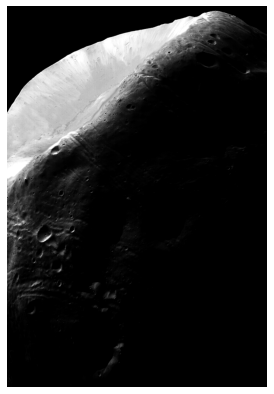

In [199]:
img = read_img("Fig0310(a).tif")

## a. Reporte la función de distribución de probabilidades de las intensidades (recuerde, histograma normalizado).

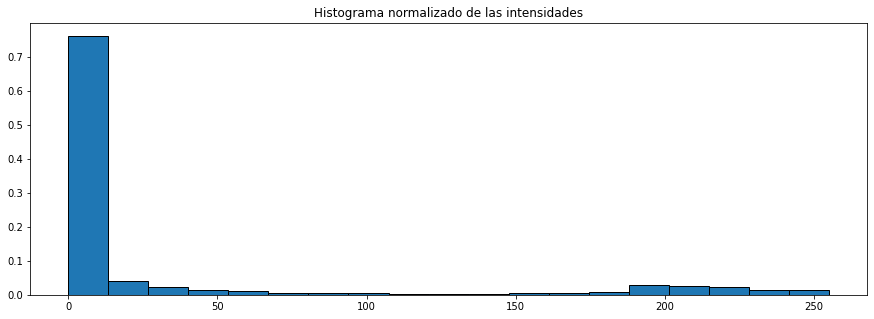

In [200]:
# Histograma normalizado
hist, bins = show_histograms(
    imgs = [img],
    titles = [
        "Histograma normalizado de las intensidades"
    ],
)

## b. Calcule la función de distribución acumulada (histograma acumulado normalizado).

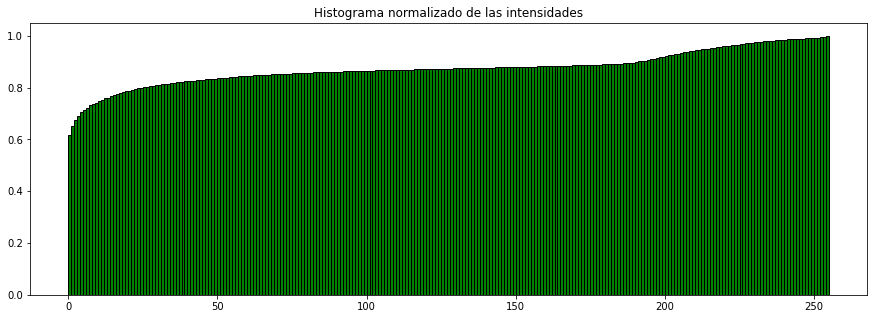

In [201]:
# Histograma acumulado
hist, bins = show_histograms(
    imgs = [img],
    titles = [
        "Histograma normalizado de las intensidades"
    ],
    cumulative = True,
    colors = ["g"],
    bin_value = 256
)

## c. Aplique la transformación de ecualización, observe que al aplicar la transformación, obtendrá una imagen entre 0 y 1 (dado que calculó la función con un histograma normalizado, ahora transforme linealmente el valor de 0 a 1 de la imagen a una nueva imagen de 0 a 255 y muestre la imagen resultante, no olvide usar los [] en imshow.

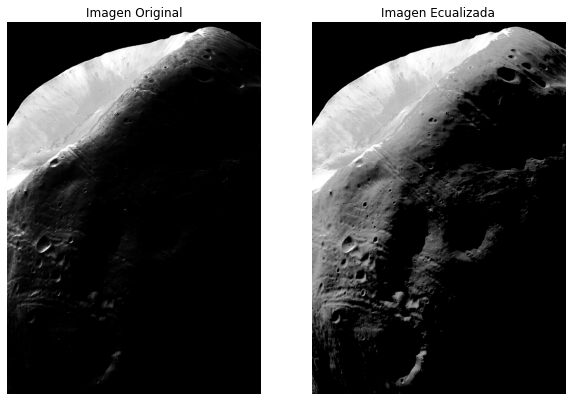

In [209]:
equ = equalize_hist(img)
show_imgs_row(
    [img, equ],
    is_gray = True,
    size = (10, 10),
    titles = [
        "Imagen Original",
        "Imagen Ecualizada",
    ]
)

Podemos notar que la función de ecualización que ya viene incluida con CV2 es más que suficiente para realizar la tarea, por lo tanto no lo tengo que programar yo ¡Hurra por mí! También note que esta función en realidad me arroja una imagen con rangos de intensidades de 0 a 255, por lo tanto no tengo que hacer ningún tipo de transformación extra.

## d. A la imagen obtenida, calcule su función de distribución de probabilidades de las intensidades ¿obtuvo una distribución uniforme?

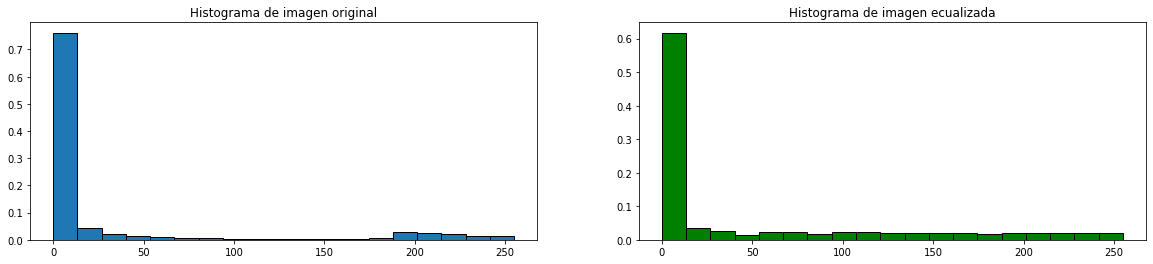

In [203]:
hists, bins = show_histograms(
    [img, equ],
    titles = [
        "Histograma de imagen original",
        "Histograma de imagen ecualizada"
    ],
    size = (20, 4),
)

## e. A la imagen obtenida, calculele la función de distribución acumulada ¿Obttuvo una rampa? ¿Qué explicación puede darle a los resultados del inciso d y e?

## f. ¿Mejora sustancialmente la ecualización para ver detalles de la luna de Marte?

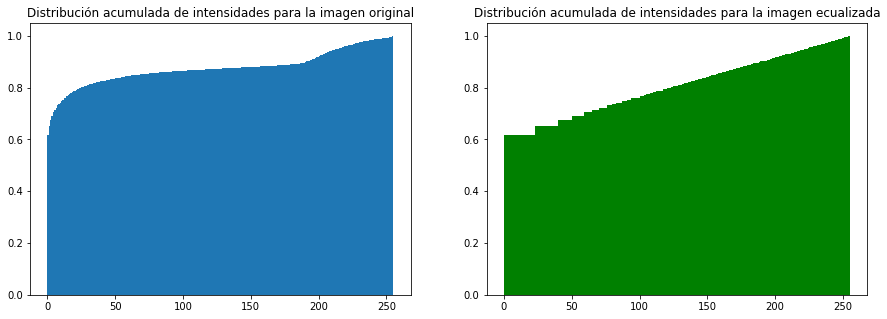

In [205]:
# Histograma acumulado
hist, bins = show_histograms(
    imgs = [img, equ],
    titles = [
        "Distribución acumulada de intensidades para la imagen original",
        "Distribución acumulada de intensidades para la imagen ecualizada"
    ],
    cumulative = True,
    bin_value = 256,
    edgecolor = None
)

La ecualización hace que obtengamos una distribución de probabilidad "más uniforme", por lo tanto tiene sentido que nuestro histograma normalizado en d. tenga más bins en lugares donde no había siquiera. Por este fenómeno podemos ver la "rampa" en el histograma acumulado.

Contestando a f. Efectivamente sí mejora bastante nuestra percepción de lo que está pasando en la imagen anterior.

# 2. Usando la imagen Fig0310(a).tif:
## a. Utilizando la función histeq de matlab repita los incisos c, d, e.
## b. Compare los resultados con los que usted obtuvo en la pregunta 1
## c. ¿Qué puede concluir al respecto?


**En mi caso no existe la función histeq y todo se programó desde 0 practicamente, por lo tanto no podría hacer estos incisos**